# 基于HDDM拟合2back任务

## 1.加载packages

In [1]:
import sys

print("Python 版本:", sys.version)

Python 版本: 3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:23:23) 
[GCC 10.3.0]


In [2]:
%matplotlib inline

# scitnific computing and plotting
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns

# HDDM related packages
import pymc as pm
import hddm
import kabuki
import arviz as az
print("The current HDDM version is: ", hddm.__version__)
print("The current kabuki version is: ", kabuki.__version__)
print("The current PyMC version is: ", pm.__version__)
print("The current ArviZ version is: ", az.__version__)

The current HDDM version is:  1.0.1RC
The current kabuki version is:  0.6.5RC4
The current PyMC version is:  2.3.8
The current ArviZ version is:  0.15.1


## 2.导入数据集

In [3]:
! pip install openpyxl


[notice] A new release of pip is available: 24.1.2 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


In [4]:
import pandas as pd
import hddm
import matplotlib.pyplot as plt
import seaborn as sns

# 读取 Excel 文件
file_path = './rawdata.xlsx'
trial_data = pd.read_excel(file_path)

# 清理列名中的空格
trial_data.columns = trial_data.columns.str.strip()

# 确保反应时间列 'rt' 被转换为浮点数类型
trial_data['rt'] = pd.to_numeric(trial_data['rt'], errors='coerce')

# 确保 'Group' 列的数据类型为字符串，并去除可能的空格
trial_data['Group'] = trial_data['Group'].astype(str).str.strip()

# 检查数据
print(trial_data.tail())
print(f"The number of trials: {trial_data.shape[0]}")
print(f"The number of variables: {trial_data.shape[1]}")
print(f"The number of participants: {trial_data['subj_idx'].unique().shape[0]}")

# 重新命名必要的列，确保与 HDDM 的要求一致
data = hddm.utils.flip_errors(trial_data)

# 数据检查完成，准备后续模型的构建

            ID  subj_idx  response     rt Group
21802  21570.0     19028         0  0.217     3
21803  21571.0     19028         1  0.172     3
21804  21572.0     19028         1  0.507     3
21805  21573.0     19028         1  0.339     3
21806  21574.0     19028         0  0.010     3
The number of trials: 21807
The number of variables: 5
The number of participants: 296


In [5]:
# 统计每个Group下各subj_idx的出现次数
group_counts = trial_data.groupby(['Group', 'subj_idx']).size().reset_index(name='Trial_Count')

# 保存统计结果为Excel
output_path = './被试trials刺激统计.xlsx'
group_counts.to_excel(output_path, index=False)

print(f"Group-wise subject trial counts saved to: {output_path}")

Group-wise subject trial counts saved to: ./被试trials刺激统计.xlsx


In [6]:
data=trial_data

In [ ]:
import matplotlib.pyplot as plt

# 分组标签映射（字符串类型）
group_labels = {
    '1': 'FES Patients',
    '2': 'ChSz Patients',
    '3': 'HC'  # 新增HC组
}

# 确保组的顺序为 ['1', '2', '3']
groups = ['1', '2', '3']

# 创建子图（这里将图像宽度适当增大以适应三个子图）
fig, axs = plt.subplots(1, len(groups), figsize=(12, 4), sharey=True, constrained_layout=True)

for idx, group in enumerate(groups):
    group_data = data[data['Group'] == group]
    ax = axs[idx]  # 当前子图
    ax.set_title(f"{group_labels[group]} RT Distribution", fontsize=14, weight='bold')
    
    # 绘制每个 subj_idx 的反应时间分布
    for subj_idx, subj_data in group_data.groupby('subj_idx'):
        subj_data.rt.hist(bins=10, histtype='step', ax=ax, alpha=0.7)
    
    ax.set_xlabel('Reaction Time (second)', fontsize=12, weight='bold')
    if idx == 0:  # 仅在第一个子图中设置 Y 轴标签
        ax.set_ylabel('Count', fontsize=12, weight='bold')
    
    # 添加网格线
    ax.grid(axis='both', linestyle='--', alpha=0.45)

# 保存图像
plt.savefig('rt_distributions_by_group_with_grid.jpg', dpi=1200, bbox_inches='tight')
plt.show()

In [8]:
# 检查 Group 列的唯一值及其数据类型
print(data['Group'].unique())
print(data['Group'].dtype)

# 确保 Group 列的值为字符串类型，并移除可能存在的空格
data['Group'] = data['Group'].astype(str).str.strip()

# 计算 Group 1、Group 2 和 Group 3 中的唯一被试数量
unique_group1_subjects = data[data['Group'] == '1']['subj_idx'].nunique()
unique_group2_subjects = data[data['Group'] == '2']['subj_idx'].nunique()
unique_group3_subjects = data[data['Group'] == '3']['subj_idx'].nunique()

print(f"First episode of schizophrenia = {unique_group1_subjects}")
print(f"Chronic schizophrenia = {unique_group2_subjects}")
print(f"HC subjects = {unique_group3_subjects}")

['1' '2' '3']
object
First episode of schizophrenia = 103
Chronic schizophrenia = 108
HC subjects = 85


#### 1.模型设计

In [9]:
# 基础模型（m0）：包含所有核心参数和变异性参数，不考虑条件或组别
m0 = hddm.HDDM(
    data, 
    include=['a', 'v', 't', 'z', 'sv', 'sz', 'st']
)

# 综合模型（m1）：分层模型，假设核心参数依赖于组别（Group）
m1 = hddm.HDDM(
    data, 
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    depends_on={
        'a': ['Group'], 
        'v': ['Group'], 
        't': ['Group'],
        'z': ['Group']
    }
)

# 回归模型：以健康对照组（组3）为参考组
m2v = hddm.HDDMRegressor(
    data,
    "v ~ 1 + C(Group, Treatment('3'))",  # 漂移率 v 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)

m2z = hddm.HDDMRegressor(
    data,
    "z ~ 1 + C(Group, Treatment('3'))",  # 起始点 z 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)

m2a = hddm.HDDMRegressor(
    data,
    "a ~ 1 + C(Group, Treatment('3'))",  # 决策界限 a 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)

m2t = hddm.HDDMRegressor(
    data,
    "t ~ 1 + C(Group, Treatment('3'))",  # 非决策时间 t 的回归公式
    include=['a', 'v', 't', 'z', 'sv', 'st', 'sz'],
    group_only_regressors=False,
    keep_regressor_trace=True
)



print('ok')

No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
No model attribute --> setting up standard HDDM
Set model to full_ddm
ok


### 单独组别1和2差异

#### 2.模型拟合参数量 

In [10]:
def run_sampling(
    m,
    n_samples=15000,  # 10,000
    n_burn=5000,     # 5000
    n_chains=4,      # 4
    thin=2,  # Thinning：每隔2个样本保留1个
    model_name="m",
    progress_bar=True
):
    m_infdata = m.sample(
        n_samples,
        burn=n_burn,
        chains=n_chains,
        return_infdata=True,
        save_name="8.model_fitted/" + model_name,
        progress_bar=progress_bar
    )

    return m, m_infdata


# 计算时间估计
print('拟合参数设置成功!')

拟合参数设置成功!


In [ ]:
import time
import dill as pickle  # 使用dill代替pickle

# 模型和名称列表
models = [m2v]
model_names = ["m2v"]

# 创建一个字典存储结果
results = {}

for model, name in zip(models, model_names):
    print(f"Running model {name}... 🏃🏃🏃")
    start_time = time.time()
    
    # 运行采样
    model, model_infdata = run_sampling(model, model_name=name)
    elapsed_time = time.time() - start_time
    
    # 保存模型和结果
    with open(f'./2.模型拟合-输出/{name}_model.pkl', 'wb') as f_model:
        pickle.dump(model, f_model)
        
    with open(f'./2.模型拟合-输出/{name}_infdata.pkl', 'wb') as f_infdata:
        pickle.dump(model_infdata, f_infdata)
    
    results[name] = (model, model_infdata)
    
    print(f"Model {name} completed in {elapsed_time:.2f} seconds.\n")
    print(f"Model {name} and inference data saved as {name}_model.pkl and {name}_infdata.pkl.\n")

print('模型训练全部完成 😂!')

Running model m2v... 🏃🏃🏃


/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/opt/conda/lib/python3.9/site-packages/scipy/optimize/_optimize.py:2309: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)


[                  0%                  ] 2 of 20000 complete in 4.6 sec
[                  0%                  ] 3 of 20000 complete in 8.1 sec
[                  0%                  ] 4 of 20000 complete in 11.8 sec
[                  0%                  ] 5 of 20000 complete in 17.2 sec
[                  0%                  ] 6 of 20000 complete in 22.2 sec
[                  0%                  ] 7 of 20000 complete in 27.1 sec
[                  0%                  ] 8 of 20000 complete in 31.6 sec
[                  0%                  ] 9 of 20000 complete in 36.2 sec
[                  0%                  ] 10 of 20000 complete in 40.3 sec
[                  0%                  ] 11 of 20000 complete in 45.0 sec
[                  0%                  ] 12 of 20000 complete in 49.3 sec
[                  0%                  ] 13 of 20000 complete in 54.1 sec
[                  0%                  ] 14 of 20000 complete in 58.4 sec
[                  0%                  ] 15 of 2

**注：在配备 2.90GHz 英特尔®酷睿™i7-10700 处理器的电脑上，用上述设置（10000 个样本）拟合所有这六个模型大约需要 8-9 个小时。此外，内存应足够大，建议使用 ~ 64 G 内存。否则，建议使用少量样本（如 n_samples=2500，burn=1000）。

#### 3.读取之前好的模型😂

In [11]:
import pickle

# 模型和推断数据的文件名
model_names = ["m1"] 
 
# 创建字典存储模型和推断数据
models = {}
infdata = {}

# 加载所有模型和推断数据
for name in model_names:
    model_file_path = f'./2.模型拟合-输出/{name}_model.pkl'
    infdata_file_path = f'./2.模型拟合-输出/{name}_infdata.pkl'
    
    # 重新加载模型
    with open(model_file_path, 'rb') as f_model:
        models[name] = pickle.load(f_model)
    
    # 重新加载推断数据
    with open(infdata_file_path, 'rb') as f_infdata:
        infdata[name] = pickle.load(f_infdata)
    
    # 动态赋值回原始变量名
    globals()[name] = models[name]
    globals()[f"{name}_infdata"] = infdata[name]
    
    print(f"{name} 已经成功挂载!")

# 打印已加载的模型和推断数据
for name in model_names:
    print(f"{name} 模型:", globals()[name])
    print(f"{name} 推断数据:", globals()[f"{name}_infdata"])

print('所有模型和推断数据读取成功!😂')

m1 已经成功挂载!
m1 模型: <hddm.models.hddm_info.HDDM object at 0xffff6b75df70>
m1 推断数据: Inference data with groups:
	> posterior
	> observed_data
所有模型和推断数据读取成功!😂


In [12]:
import pickle

# 定义模型名称列表
model_names = ["m1"]
posterior_distributions = {}

# 循环加载每个模型并提取后验分布
for model_name in model_names:
    print(f"提取 {model_name} 的后验分布...")
    
    # 加载模型
    with open(f'./2.模型拟合-输出/{model_name}_model.pkl', 'rb') as f_model:
        model_loaded = pickle.load(f_model)
    
    # 提取后验分布
    posterior_samples = model_loaded.get_traces()
    
    # 将每个模型的后验分布存储在字典中
    posterior_distributions[model_name] = posterior_samples
    
    # 打印提取的后验分布的前几行
    print(f"{model_name}的后验分布提取完成:")

print("所有模型的后验分布提取完成！😂")


#得20分钟

提取 m1 的后验分布...
m1的后验分布提取完成:
所有模型的后验分布提取完成！😂


#### 4.查看内存

In [13]:
import psutil
print(f"Available memory: {psutil.virtual_memory().available / (1024**3):.2f} GB")

Available memory: 15.25 GB


## 3.模型诊断

In [ ]:
import arviz as az
import pandas as pd

# 获取每个模型中存储的变量名称并排除含有 'subj' 的变量
model_data = {}
filtered_model_data = {}

# 模型 m0 到 m4 的变量存储
for i, infdata in enumerate([m0_infdata]):
    model_name = f'm{i}'  # m0, m1, m2, m3, m4
    # 获取变量名称
    var_names = list(infdata.posterior.data_vars)
    model_data[model_name] = var_names
    
    # 排除包含 'subj' 的变量
    filtered_var_names = [var for var in var_names if 'subj' not in var]
    filtered_model_data[model_name] = filtered_var_names

# 将完整数据转换为 DataFrame 并保存到 Excel
df_model_data = pd.DataFrame.from_dict(model_data, orient='index').transpose()
df_model_data.to_excel('3.模型诊断-输出/model_variables_full.xlsx', index=False)

# 将排除含有 'subj' 的数据保存到另一个 Excel
df_filtered_model_data = pd.DataFrame.from_dict(filtered_model_data, orient='index').transpose()
df_filtered_model_data.to_excel('3.模型诊断-输出/model_variables_filtered.xlsx', index=False)

# 打印过滤后的模型变量名称
print('保存完成！')

#### （1）方法1.Trace plot

We can also only plot selected parameters' traces. 
 
- use regex to select var_names that start with "a" and do not contain either "subj" or "std".

print(tmp_infdata.posterior.dims)
print(tmp_infdata.posterior.coords)
print(tmp_infdata.posterior.data_vars)##### M0

KeyError: "No variable named 'a'. Variables on the dataset include ['a(1)', 'a(2)', 'a(3)', 'a_std', 'a_subj(1).4', ..., 'z_subj(3).9057', 'z_subj(3).9058', 'z_subj(3).19028', 'chain', 'draw']"

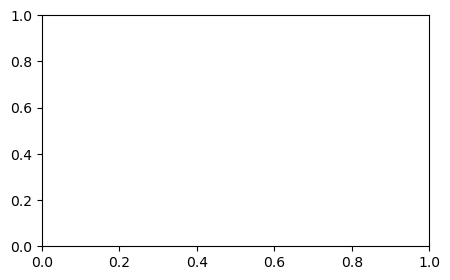

In [ ]:
import matplotlib.pyplot as plt
import os  # 导入 os 模块以创建文件夹

# 模型名称列表
model_names = ['m1']  

# 定义需要检查的参数
parameters = ['a', 'v', 't', 'z', 'sv', 'sz', 'st']

# 自定义 chain 颜色（为4个链设置颜色）

chain_colors = ['#D55E00', '#0072B2', '#F0E442']  # 高对比Nature风格配色
# 外部循环，遍历每个模型
for model_name in model_names:
    # 获取加载的推断数据
    tmp_infdata = globals()[f'{model_name}_infdata']
    
    # 为每个模型创建文件夹
    output_folder = f'3.模型诊断-输出/{model_name}'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 内部循环，遍历每个参数，生成 trace plot
    for param in parameters:
        # 确定 var_names 列表（直接基于参数名称）
        var_names = [f'{param}']  # 如果变量名有其他特定规则，可以调整生成逻辑

        # 手动绘制每个链的轨迹
        for var_name in var_names:
            fig, ax = plt.subplots(figsize=(5, 3))

            # 手动绘制每条链
            for i, color in enumerate(chain_colors):
                chain_data = tmp_infdata.posterior[var_name].sel(chain=i)
               
                ax.plot(chain_data, color=color, label=f'chain {i}', linestyle='-.', linewidth=1.2)
            # 添加 X 轴和 Y 轴标签，并设置字体为粗体，增加 pad
            ax.set_xlabel("MCMC Sampling Iterations", fontsize=12, fontweight='bold', labelpad=10)  # 设置 X 轴标签，增加 pad 和粗体
            ax.set_ylabel(f'Value', fontsize=12, fontweight='bold', labelpad=10)  # 设置 Y 轴标签，增加 pad 和粗体

            # 设置标题，将 var_name 和 'Trace Plot' 结合
            ax.set_title(f'{param} Parameter Trace Plot', fontsize=14, fontweight='bold')

            ax.grid(True, linestyle='--', alpha=0.7)
            ax.legend(
                fontsize=10, 
                frameon=False,  # 去掉外边框
                ncol=4, 
                fancybox=True, 
                bbox_to_anchor=(1.05, -0.23)
            )

            # 保存图片为 600 DPI 的 JPEG 格式到对应模型的文件夹
            plt.savefig(f'{output_folder}/{model_name}_{param}_trace_plot.jpg', dpi=1200, format='jpg', bbox_inches='tight')
            plt.show()

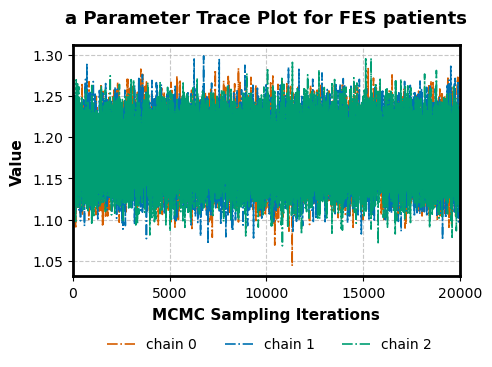

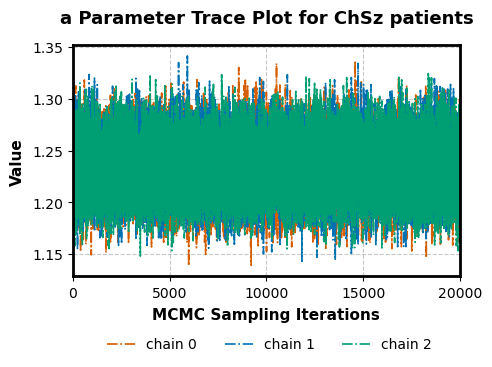

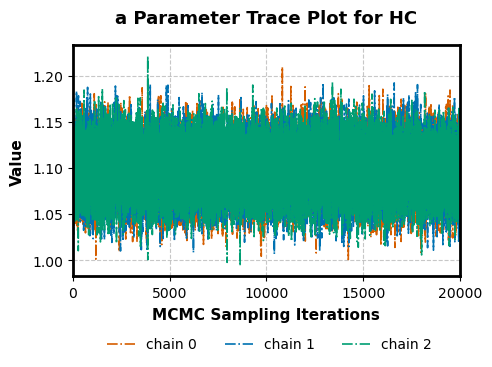

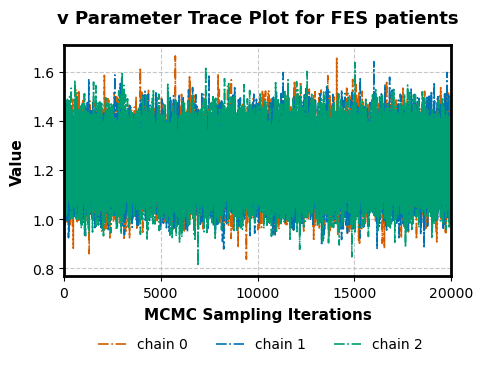

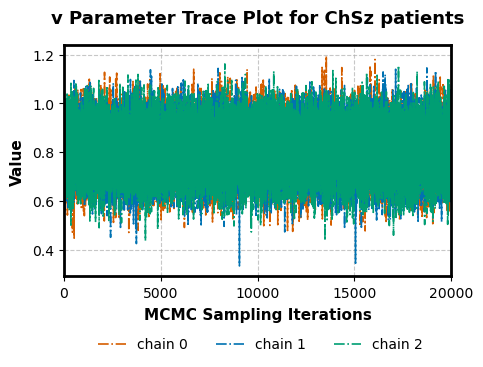

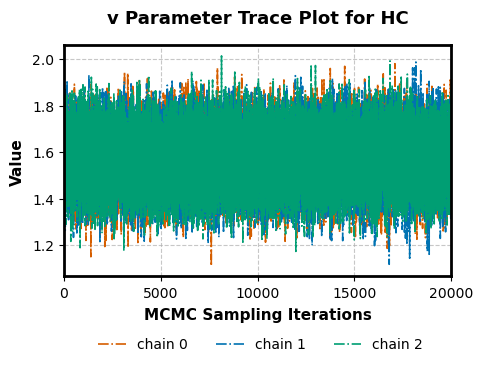

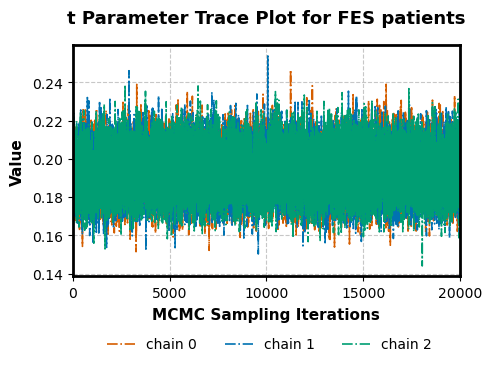

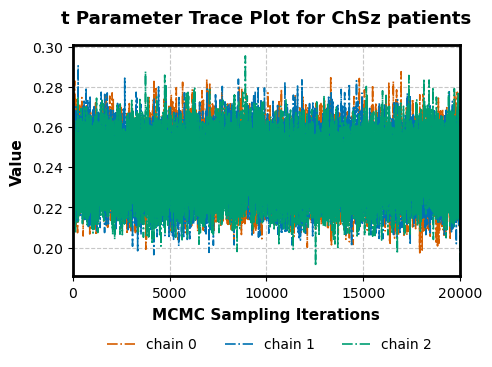

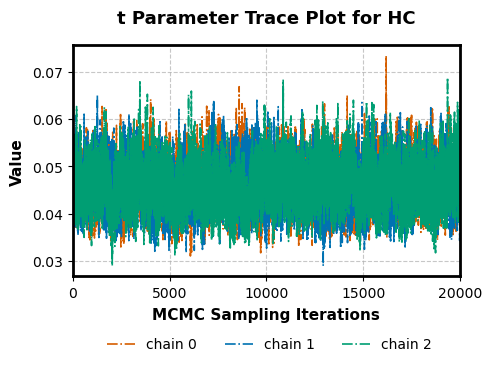

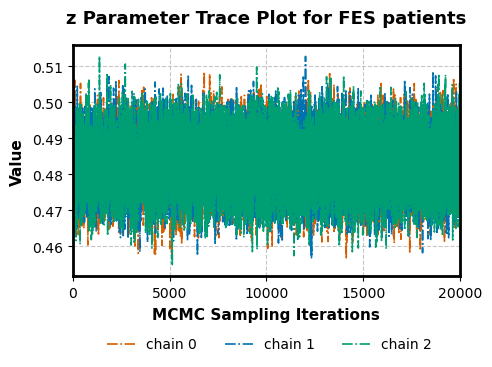

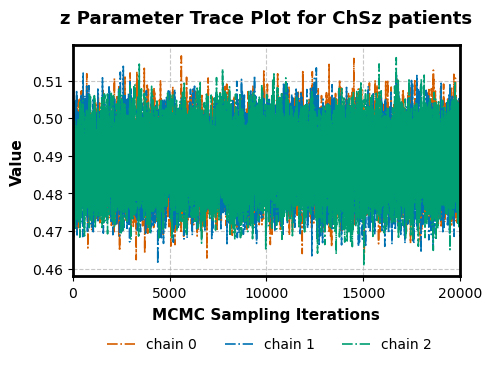

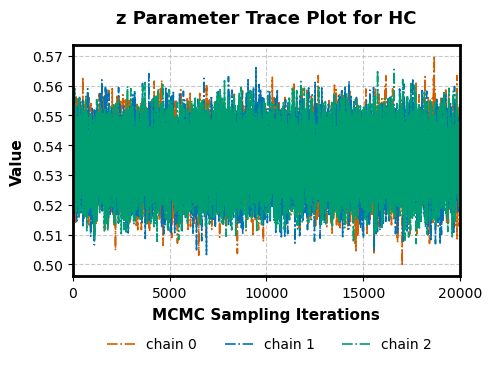

In [40]:
import matplotlib.pyplot as plt
import os  # 导入 os 模块以创建文件夹

# 模型名称列表
model_names = ['m1']  

# 定义需要检查的参数，增加 (3) 对应 HC
parameters = ['a(1)', 'a(2)', 'a(3)', 'v(1)', 'v(2)', 'v(3)', 't(1)', 't(2)', 't(3)', 'z(1)', 'z(2)', 'z(3)']

# 自定义 chain 颜色（为3个链设置颜色）
chain_colors = ['#D55E00', '#0072B2', '#009E73']  # 高对比 Nature 风格配色

# 模型的患者组信息，增加 (3) 对应 HC
model_patient_groups = {
    'a(1)': 'FES patients',
    'a(2)': 'ChSz patients',
    'a(3)': 'HC',
    'v(1)': 'FES patients',
    'v(2)': 'ChSz patients',
    'v(3)': 'HC',
    't(1)': 'FES patients',
    't(2)': 'ChSz patients',
    't(3)': 'HC',
    'z(1)': 'FES patients',
    'z(2)': 'ChSz patients',
    'z(3)': 'HC',
    'sv': 'FES patients',
    'st': 'ChSz patients'
}

# 外部循环，遍历每个模型
for model_name in model_names:
    # 获取加载的推断数据
    tmp_infdata = globals()[f'{model_name}_infdata']
    
    # 为每个模型创建文件夹
    output_folder = f'3.模型诊断-输出/{model_name}'
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # 内部循环，遍历每个参数，生成 trace plot
    for param in parameters:
        # 对于参数 a，交换 a(1) 和 a(3) 的数据：即当 param 为 a(1) 时，使用 a(3) 的数据；当 param 为 a(3) 时，使用 a(1) 的数据
        if param == 'a(1)':
            var_name = 'a(3)'
        elif param == 'a(3)':
            var_name = 'a(1)'
        else:
            var_name = param

        # 移除参数中的数字括号部分，例如 'a(1)' 变为 'a'
        param_clean = param.split('(')[0]  # 仅保留参数名称的前部分
        
        # 手动绘制每个链的轨迹
        fig, ax = plt.subplots(figsize=(5, 3))

        # 手动绘制每条链
        for i, color in enumerate(chain_colors):
            chain_data = tmp_infdata.posterior[var_name].sel(chain=i)
            ax.plot(chain_data, color=color, label=f'chain {i}', linestyle='-.', linewidth=1.2)
        
        # 设置 X 轴刻度为 0~20000, 间隔 5000
        ax.set_xlim(0, 20000)
        ax.set_xticks(range(0, 20001, 5000))
        
        # 添加 X 轴和 Y 轴标签，并设置字体为粗体，增加 pad
        ax.set_xlabel("MCMC Sampling Iterations", fontsize=11, fontweight='bold', labelpad=5)
        ax.set_ylabel("Value", fontsize=11, fontweight='bold', labelpad=5)

        # 获取患者组信息，并生成合适的标题
        patient_group = model_patient_groups.get(param, 'Unknown group')
        ax.set_title(f'{param_clean} Parameter Trace Plot for {patient_group}', fontsize=13, fontweight='bold', y=1.06)

        # 设置边框颜色为黑色，并加粗
        ax.spines['top'].set_color('black')
        ax.spines['top'].set_linewidth(2)
        ax.spines['bottom'].set_color('black')
        ax.spines['bottom'].set_linewidth(2)
        ax.spines['left'].set_color('black')
        ax.spines['left'].set_linewidth(2)
        ax.spines['right'].set_color('black')
        ax.spines['right'].set_linewidth(2)
        
        ax.grid(True, linestyle='--', alpha=0.7)
        ax.legend(
            fontsize=10, 
            frameon=False,  # 去掉外边框
            ncol=4, 
            fancybox=True, 
            bbox_to_anchor=(0.96, -0.21)
        )

        # 保存每个参数的 Trace Plot，确保文件名包含每个参数
        output_file_path = f'{output_folder}/{model_name}_{param}_trace_plot.jpg'
        plt.savefig(output_file_path, dpi=1200, format='jpg', bbox_inches='tight')
        plt.show()

#### （2）方法2. $\hat{R}$ and ESS

In [15]:
import pandas as pd
import arviz as az

# 假设你已经在之前的代码中动态加载了推断数据
model_data = [m1_infdata]  # 使用正确的全局变量名
model_names = ['m1']

# 循环处理每个模型
for model_name, tmp_infdata in zip(model_names, model_data):
    
    # 获取R-hat大于1.1的参数及其诊断统计量
    summary_tmp = az.summary(tmp_infdata, kind="diagnostics", round_to=4)
    problem_params = summary_tmp[summary_tmp["r_hat"] > 1.1]

    # 打印问题参数
    print(f"问题参数😭 - {model_name}:")
    print(problem_params)

    # 将问题参数保存为Excel文件
    problem_params.to_excel(f"3.模型诊断-输出/problem_params-{model_name}.xlsx", index=True)
    print(f"已成功将问题参数保存至 problem_params-{model_name}.xlsx 文件")

    # 获取R-hat小于等于1.1的参数
    good_params = summary_tmp[summary_tmp["r_hat"] <= 1.1]

    # 打印收敛良好的参数
    print(f"收敛良好的参数😂 - {model_name}:")
    print(good_params)

    # 将收敛良好的参数保存为Excel文件
    good_params.to_excel(f"3.模型诊断-输出/good_params-{model_name}.xlsx", index=True)
    print(f"已成功将收敛良好的参数保存至 good_params-{model_name}.xlsx 文件")

    # 只计算 ESS
    ess_values = az.ess(tmp_infdata).values
    print(f"模型 {model_name} 的 ESS 值：")
    print(ess_values)


问题参数😭 - m1:
Empty DataFrame
Columns: [mcse_mean, mcse_sd, ess_bulk, ess_tail, r_hat]
Index: []
已成功将问题参数保存至 problem_params-m1.xlsx 文件
收敛良好的参数😂 - m1:
                 mcse_mean  mcse_sd    ess_bulk    ess_tail   r_hat
a(1)                0.0001   0.0001  32081.7170  37807.6555  1.0000
a(2)                0.0002   0.0001  27717.9883  37609.2625  1.0001
a(3)                0.0002   0.0001  28346.5298  38133.7983  1.0000
a_std               0.0001   0.0001  17154.5867  29722.8506  1.0008
a_subj(1).4         0.0003   0.0002  31910.4609  35222.0840  1.0002
...                    ...      ...         ...         ...     ...
z_subj(3).9054      0.0002   0.0001  41362.4633  39709.2279  1.0001
z_subj(3).9055      0.0003   0.0002   9596.3734  29095.5293  1.0010
z_subj(3).9057      0.0002   0.0001  34880.5837  40599.0623  1.0000
z_subj(3).9058      0.0003   0.0002  25716.5817  33555.3851  1.0002
z_subj(3).19028     0.0005   0.0004   9715.1898  24348.9631  1.0001

[1203 rows x 5 columns]
已成功将收敛良好的参数

## 4. 模型比较与选择 (基于DIC)

In [ ]:
! pip3 install tabulate

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 模拟DIC数据，使用模型的具体名称
dic_dict = {
    "Model 1": m0.dic,
    "Model 0": m1.dic,
}

# 将字典转换为Pandas DataFrame,并按照DIC值升序排序
comp_dic = pd.DataFrame.from_dict(dic_dict, orient='index', columns=['DIC'])
comp_dic['model'] = comp_dic.index
comp_dic = comp_dic[['model', 'DIC']]
comp_dic = comp_dic.sort_values(by=['DIC'], ascending=True)

# 打印三线表
print(comp_dic.to_markdown(index=False, tablefmt="grid"))

# 设置绘图风格，使用符合Nature风格的简洁主题
sns.set(style="whitegrid", font_scale=1.2)

# 创建颜色映射，颜色越大越深
norm = plt.Normalize(comp_dic['DIC'].min(), comp_dic['DIC'].max())
colors = plt.cm.viridis(norm(comp_dic['DIC']))  # 使用 vivid 色彩映射

# 创建柱状图，将 X 和 Y 轴对调
plt.figure(figsize=(6, 5))
bar_plot = sns.barplot(y='model', x='DIC', data=comp_dic, palette=colors)

# 为柱状图中的每个柱子设置透明度、边框粗细和花纹
for patch in bar_plot.patches:
    patch.set_alpha(0.7)  # 设置透明度为0.7
    patch.set_edgecolor('black')  # 设置边框颜色为黑色
    patch.set_linewidth(0.6)  # 设置边框粗细为0.6
    patch.set_hatch('/')  # 设置花纹，'/'表示斜线

# 在柱子上标注具体数值
for i, patch in enumerate(bar_plot.patches):
    width = patch.get_width()
    bar_plot.text(width + 0.5,  # 数值标签的x坐标稍高于柱子顶部
                  patch.get_y() + patch.get_height() / 2,
                  f'{width:.2f}',  # 显示2位小数
                  ha='left', 
                  va='center', 
                  fontsize=8, 
                  weight='bold')

# 添加图形标题和坐标轴标签
bar_plot.set_ylabel("Model", fontsize=12, weight='bold')
bar_plot.set_xlabel("DIC Value", fontsize=12, weight='bold')

# 调整标签和风格，参考Nature风格
bar_plot.tick_params(axis='both', which='major', labelsize=12)
bar_plot.spines['top'].set_visible(False)
bar_plot.spines['right'].set_visible(False)

# 设置左和底部的边框为黑色，并加粗
bar_plot.spines['left'].set_linewidth(1.5)
bar_plot.spines['left'].set_color('black')  # 改为黑色
bar_plot.spines['bottom'].set_linewidth(2)
bar_plot.spines['bottom'].set_color('black')  # 改为黑色

# 设置网格线的透明度和粗细
bar_plot.grid(True, which='major', axis='x', linestyle='-.', linewidth=0.8, alpha=0.8)  # 现在对x轴应用网格线
bar_plot.grid(True, which='major', axis='y', linestyle='-.', linewidth=0.8, alpha=0.8)

# 调整布局以防止标签被截断
plt.tight_layout()

# 保存图片到指定文件夹，并确保不会截断图像
plt.savefig("4.模型比较-输出/DIC_comparison.jpeg", dpi=600, format='jpeg', bbox_inches='tight')  # 使用bbox_inches='tight'来防止截断

# 显示图形
plt.show()

In [ ]:
# 计算模型间的 DIC 差异
comp_dic['ΔDIC'] = comp_dic['DIC'] - comp_dic['DIC'].min()

# 打印三线表
print(comp_dic.to_markdown(index=False, tablefmt="grid"))

## 5. 统计推断

### 1.查看字段 + 输出后验参数

In [ ]:
import pandas as pd
import numpy as np

# 只使用m1模型
model = m1_infdata  # 直接使用m1模型，不需要列表

# 创建一个 Excel writer
with pd.ExcelWriter('6.统计推断-输出/models_infdata_posterior_means-m1.xlsx') as writer:
    try:
        # 获取后验样本
        posterior_samples = model.posterior
        
        # 创建存储结果的字典
        results_dict = {}
        
        # 遍历posterior中的所有变量
        for var_name in posterior_samples.keys():
            # 检查是否是个体参数（包含subj字样）
            if 'subj' in var_name:
                # 提取参数类型（如 'a', 'v', 't', 'z'）
                param_type = var_name.split('.')[0]
                # 提取被试编号
                subj = var_name.split('.')[-1]
                
                # 计算后验均值
                posterior_mean = posterior_samples[var_name].values.mean()
                
                # 存储结果
                if subj not in results_dict:
                    results_dict[subj] = {}
                results_dict[subj][param_type] = posterior_mean
        
        # 只有在有数据时才创建DataFrame和写入Excel
        if results_dict:
            # 转换为DataFrame
            df = pd.DataFrame.from_dict(results_dict, orient='index')
            df.index.name = 'subject'
            
            # 写入Excel
            df.to_excel(writer, sheet_name='m1_posterior_means')
            print("m1模型: 写入成功！")
        else:
            print("m1模型: 没有找到个体参数数据")
        
    except Exception as e:
        print(f"写入失败！错误信息：{e}")

print("存储完成！")

### 2.查看参数

In [ ]:
models = [m1]
model_names = ["m1"]

for i, model in enumerate(models):
    print(f"{model_names[i]} nodes_db columns:")
    print(model.nodes_db.columns)
    print("\n" + "="*50 + "\n")

### 3.是否在Group存在显著差异

In [42]:
import numpy as np

def bayesian_analysis(data1, data2, rope_bounds=(-0.2, 0.2)):
    """
    执行贝叶斯分析，使用更窄的ROPE区间
    """
    diff_dist = data1 - data2
    mean_diff = np.mean(diff_dist)
    hdi_low, hdi_high = np.percentile(diff_dist, [2.5, 97.5])
    
    # 计算标准化效应量
    pooled_std = np.sqrt((np.var(data1) + np.var(data2)) / 2)
    effect_size = mean_diff / pooled_std if pooled_std != 0 else np.nan
    
    # 使用更窄的ROPE计算PP|D
    ppd = np.mean((diff_dist > rope_bounds[0]) & (diff_dist < rope_bounds[1]))
    ppd = np.clip(ppd, 0.001, 0.999)  # 避免极端值
    
    # 计算BF₁₀
    bf10 = (1 - ppd) / ppd
    
    return {
        'mean_diff': mean_diff,
        'hdi_low': hdi_low,
        'hdi_high': hdi_high,
        'ppd': ppd,
        'bf10': bf10,
        'effect_size': effect_size
    }

# 打印表头
print("\nComparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀")
print("─" * 100)

# 参数名称列表（这里包含a, v, t, z），被试组别现在为1, 2, 3
parameter_names = ['a']
groups = [1, 2, 3]

# 遍历所有参数，对于每个参数，进行组间两两比较
for param in parameter_names:
    # 对每组样本进行pairwise比较： (1 vs 2), (1 vs 3), (2 vs 3)
    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            group1 = groups[i]
            group2 = groups[j]
            # 构建对应列名称，假设m1_infdata.posterior中有类似 "a(1)", "a(2)", "a(3)" 的数据
            col1 = f"{param}({group1})"
            col2 = f"{param}({group2})"
            
            fes_samples = m1_infdata.posterior[col1].values.flatten()  # FES 样本
            chsz_samples = m1_infdata.posterior[col2].values.flatten()  # ChSz 样本
            
            # 执行贝叶斯分析
            results = bayesian_analysis(fes_samples, chsz_samples)
            
            # 打印结果
            print(f"{col1} vs {col2} │ {np.mean(fes_samples):12.3f} │ {np.mean(chsz_samples):12.3f} │ "
                  f"{results['mean_diff']:14.3f} │ {results['hdi_low']:13.3f} │ {results['hdi_high']:13.3f} │ "
                  f"{results['ppd']:4.3f} │ {results['bf10']:>6.2f}")


Comparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀
────────────────────────────────────────────────────────────────────────────────────────────────────
a(1) vs a(2) │        1.098 │        1.235 │         -0.137 │        -0.204 │        -0.069 │ 0.967 │   0.03
a(1) vs a(3) │        1.098 │        1.181 │         -0.083 │        -0.155 │        -0.012 │ 0.999 │   0.00
a(2) vs a(3) │        1.235 │        1.181 │          0.053 │        -0.018 │         0.126 │ 0.999 │   0.00


In [43]:
import numpy as np

def bayesian_analysis(data1, data2, rope_bounds=(-0.2, 0.2)):
    """
    执行贝叶斯分析，使用更窄的ROPE区间
    """
    diff_dist = data1 - data2
    mean_diff = np.mean(diff_dist)
    hdi_low, hdi_high = np.percentile(diff_dist, [2.5, 97.5])
    
    # 计算标准化效应量
    pooled_std = np.sqrt((np.var(data1) + np.var(data2)) / 2)
    effect_size = mean_diff / pooled_std if pooled_std != 0 else np.nan
    
    # 使用更窄的ROPE计算PP|D
    ppd = np.mean((diff_dist > rope_bounds[0]) & (diff_dist < rope_bounds[1]))
    ppd = np.clip(ppd, 0.001, 0.999)  # 避免极端值
    
    # 计算BF₁₀
    bf10 = (1 - ppd) / ppd
    
    return {
        'mean_diff': mean_diff,
        'hdi_low': hdi_low,
        'hdi_high': hdi_high,
        'ppd': ppd,
        'bf10': bf10,
        'effect_size': effect_size
    }

# 打印表头
print("\nComparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀")
print("─" * 100)

# 参数名称列表（这里包含a, v, t, z），被试组别现在为1, 2, 3
parameter_names = ['v']  # 修改为计算参数 v
groups = [1, 2, 3]

# 遍历所有参数，对于每个参数，进行组间两两比较
for param in parameter_names:
    # 对每组样本进行pairwise比较： (1 vs 2), (1 vs 3), (2 vs 3)
    for i in range(len(groups)):
        for j in range(i+1, len(groups)):
            group1 = groups[i]
            group2 = groups[j]
            # 构建对应列名称，假设 m1_infdata.posterior 中有类似 "v(1)", "v(2)", "v(3)" 的数据
            col1 = f"{param}({group1})"
            col2 = f"{param}({group2})"
            
            fes_samples = m1_infdata.posterior[col1].values.flatten()  # FES 样本
            chsz_samples = m1_infdata.posterior[col2].values.flatten()  # ChSz 样本
            
            # 执行贝叶斯分析
            results = bayesian_analysis(fes_samples, chsz_samples)
            
            # 打印结果
            print(f"{col1} vs {col2} │ {np.mean(fes_samples):12.3f} │ {np.mean(chsz_samples):12.3f} │ "
                  f"{results['mean_diff']:14.3f} │ {results['hdi_low']:13.3f} │ {results['hdi_high']:13.3f} │ "
                  f"{results['ppd']:4.3f} │ {results['bf10']:>6.2f}")


Comparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀
────────────────────────────────────────────────────────────────────────────────────────────────────
v(1) vs v(2) │        1.233 │        0.807 │          0.426 │         0.168 │         0.683 │ 0.043 │  22.20
v(1) vs v(3) │        1.233 │        1.570 │         -0.336 │        -0.620 │        -0.056 │ 0.172 │   4.82
v(2) vs v(3) │        0.807 │        1.570 │         -0.762 │        -1.037 │        -0.487 │ 0.001 │ 999.00


In [ ]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

def bayesian_analysis(data1, data2, rope_bounds=(-0.2, 0.2)):
    """
    执行贝叶斯分析，使用更窄的ROPE区间
    """
    diff_dist = data1 - data2
    mean_diff = np.mean(diff_dist)
    hdi_low, hdi_high = np.percentile(diff_dist, [2.5, 97.5])
    
    # 计算标准化效应量
    pooled_std = np.sqrt((np.var(data1) + np.var(data2)) / 2)
    effect_size = mean_diff / pooled_std
    
    # 使用更窄的ROPE计算PP|D
    ppd = np.mean((diff_dist > rope_bounds[0]) & (diff_dist < rope_bounds[1]))
    ppd = np.clip(ppd, 0.001, 0.999)  # 避免极端值
    
    # 计算BF₁₀
    bf10 = (1 - ppd) / ppd
    
    return {
        'mean_diff': mean_diff,
        'hdi_low': hdi_low,
        'hdi_high': hdi_high,
        'ppd': ppd, 
        'bf10': bf10,
        'effect_size': effect_size
    }

# 打印表头  
print("\nComparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀")
print("─" * 100)

# 提取a(1)和a(2)的后验样本
a1_samples = m1_infdata.posterior['a(1)'].values.flatten()
a2_samples = m1_infdata.posterior['a(2)'].values.flatten()

# 执行贝叶斯分析
results = bayesian_analysis(a1_samples, a2_samples)

# 打印结果
print(f"a(1) vs a(2) │ {np.mean(a1_samples):12.3f} │ {np.mean(a2_samples):12.3f} │ "
      f"{results['mean_diff']:14.3f} │ {results['hdi_low']:13.3f} │ {results['hdi_high']:13.3f} │ "   
      f"{results['ppd']:4.3f} │ {results['bf10']:>6.2f}")

# 配置全局样式
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12 
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5  
plt.rcParams['ytick.major.pad'] = 5

# 创建单个子图
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# 绘制后验分布图
az.plot_posterior(
    a1_samples - a2_samples,
    kind='kde',
    hdi_prob=0.95, 
    rope=[-0.2, 0.2],
    textsize=12,
    rope_color='red',
    ax=ax,
    color='black',
)

# 获取x和y坐标，用于填充
x_vals = ax.lines[0].get_xdata()
y_vals = ax.lines[0].get_ydata()

# 使用 fill_between 方法进行填充
ax.fill_between(x_vals, y_vals, color='#225ea8', alpha=0.7)

# 设置图形格式 
ax.set_xlabel(f'Difference in FES and ChSz patients on a', fontsize=12, labelpad=10)
ax.set_ylabel('Density', fontsize=12, labelpad=12)
ax.set_title(f'PP|D = {results["ppd"]:.3f}, BF {10} = {results["bf10"]:.2f}', fontsize=14, pad=15)

# 添加填充矩形
rect = plt.Rectangle((-0.2, 0), 0.4, ax.get_ylim()[1],
                     linewidth=0, facecolor='#FFC107', alpha=0.3, 
                     zorder=-1)
ax.add_patch(rect)

# 自定义图例符号
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='black', lw=4), 
    Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')
]

# 添加图例
ax.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper left', fontsize=10,
          frameon=False, edgecolor='none', fancybox=False,
          borderpad=0.5, handlelength=1.5, handletextpad=0.5)

# 调整布局和显示图像
plt.tight_layout()
plt.savefig('./6.统计推断-输出/m1/a1_vs_a2_comparison.jpg', dpi=1200, bbox_inches='tight')  
plt.show()

In [ ]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

def bayesian_analysis(data1, data2, rope_bounds=(-0.2, 0.2)):
    """
    执行贝叶斯分析，使用更窄的ROPE区间
    """
    diff_dist = data1 - data2
    mean_diff = np.mean(diff_dist)
    hdi_low, hdi_high = np.percentile(diff_dist, [2.5, 97.5])
    
    # 计算标准化效应量
    pooled_std = np.sqrt((np.var(data1) + np.var(data2)) / 2)
    effect_size = mean_diff / pooled_std
    
    # 使用更窄的ROPE计算PP|D
    ppd = np.mean((diff_dist > rope_bounds[0]) & (diff_dist < rope_bounds[1]))
    ppd = np.clip(ppd, 0.001, 0.999)  # 避免极端值
    
    # 计算BF₁₀
    bf10 = (1 - ppd) / ppd
    
    return {
        'mean_diff': mean_diff,
        'hdi_low': hdi_low,
        'hdi_high': hdi_high,
        'ppd': ppd, 
        'bf10': bf10,
        'effect_size': effect_size
    }

# 打印表头  
print("\nComparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀")
print("─" * 100)

# 提取a(1)和a(2)的后验样本
a1_samples = m1_infdata.posterior['v(1)'].values.flatten()
a2_samples = m1_infdata.posterior['v(2)'].values.flatten()

# 执行贝叶斯分析
results = bayesian_analysis(a1_samples, a2_samples)

# 打印结果
print(f"v(1) vs v(2) │ {np.mean(a1_samples):12.3f} │ {np.mean(a2_samples):12.3f} │ "
      f"{results['mean_diff']:14.3f} │ {results['hdi_low']:13.3f} │ {results['hdi_high']:13.3f} │ "   
      f"{results['ppd']:4.3f} │ {results['bf10']:>6.2f}")

# 配置全局样式
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12 
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5  
plt.rcParams['ytick.major.pad'] = 5

# 创建单个子图
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# 绘制后验分布图
az.plot_posterior(
    a1_samples - a2_samples,
    kind='kde',
    hdi_prob=0.95, 
    rope=[-0.2, 0.2],
    textsize=12,
    rope_color='red',
    ax=ax,
    color='black',
)

# 获取x和y坐标，用于填充
x_vals = ax.lines[0].get_xdata()
y_vals = ax.lines[0].get_ydata()

# 使用 fill_between 方法进行填充
ax.fill_between(x_vals, y_vals, color='#225ea8', alpha=0.7)

# 设置图形格式 
ax.set_xlabel(f'Difference in FES and ChSz patients on v', fontsize=12, labelpad=10)
ax.set_ylabel('Density', fontsize=12, labelpad=12)
ax.set_title(f'PP|D = {results["ppd"]:.3f}, BF {10} = {results["bf10"]:.2f}', fontsize=14, pad=15)

# 添加填充矩形
rect = plt.Rectangle((-0.2, 0), 0.4, ax.get_ylim()[1],
                     linewidth=0, facecolor='#FFC107', alpha=0.3, 
                     zorder=-1)
ax.add_patch(rect)

# 自定义图例符号
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='black', lw=4), 
    Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')
]

# 添加图例
ax.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper left', fontsize=10,
          frameon=False, edgecolor='none', fancybox=False,
          borderpad=0.5, handlelength=1.5, handletextpad=0.5)

# 调整布局和显示图像
plt.tight_layout()
plt.savefig('./6.统计推断-输出/m1/v1_vs_v2_comparison.jpg', dpi=1200, bbox_inches='tight')  
plt.show()

In [ ]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

def bayesian_analysis(data1, data2, rope_bounds=(-0.2, 0.2)):
    """
    执行贝叶斯分析，使用更窄的ROPE区间
    """
    diff_dist = data1 - data2
    mean_diff = np.mean(diff_dist)
    hdi_low, hdi_high = np.percentile(diff_dist, [2.5, 97.5])
    
    # 计算标准化效应量
    pooled_std = np.sqrt((np.var(data1) + np.var(data2)) / 2)
    effect_size = mean_diff / pooled_std
    
    # 使用更窄的ROPE计算PP|D
    ppd = np.mean((diff_dist > rope_bounds[0]) & (diff_dist < rope_bounds[1]))
    ppd = np.clip(ppd, 0.001, 0.999)  # 避免极端值
    
    # 计算BF₁₀
    bf10 = (1 - ppd) / ppd
    
    return {
        'mean_diff': mean_diff,
        'hdi_low': hdi_low,
        'hdi_high': hdi_high,
        'ppd': ppd, 
        'bf10': bf10,
        'effect_size': effect_size
    }

# 打印表头  
print("\nComparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀")
print("─" * 100)

# 提取a(1)和a(2)的后验样本
a1_samples = m1_infdata.posterior['t(1)'].values.flatten()
a2_samples = m1_infdata.posterior['t(2)'].values.flatten()

# 执行贝叶斯分析
results = bayesian_analysis(a1_samples, a2_samples)

# 打印结果
print(f"t(1) vs t(2) │ {np.mean(a1_samples):12.3f} │ {np.mean(a2_samples):12.3f} │ "
      f"{results['mean_diff']:14.3f} │ {results['hdi_low']:13.3f} │ {results['hdi_high']:13.3f} │ "   
      f"{results['ppd']:4.3f} │ {results['bf10']:>6.2f}")

# 配置全局样式
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12 
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5  
plt.rcParams['ytick.major.pad'] = 5

# 创建单个子图
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# 绘制后验分布图
az.plot_posterior(
    a1_samples - a2_samples,
    kind='kde',
    hdi_prob=0.95, 
    rope=[-0.2, 0.2],
    textsize=12,
    rope_color='red',
    ax=ax,
    color='black',
)

# 获取x和y坐标，用于填充
x_vals = ax.lines[0].get_xdata()
y_vals = ax.lines[0].get_ydata()

ax.fill_between(x_vals, y_vals, color='#225ea8', alpha=0.7)

# 设置图形格式 
ax.set_xlabel(f'Difference in FES and ChSz patients on t', fontsize=12, labelpad=10)
ax.set_ylabel('Density', fontsize=12, labelpad=12)
ax.set_title(f'PP|D = {results["ppd"]:.3f}, BF {10} = {results["bf10"]:.2f}', fontsize=14, pad=15)

# 添加填充矩形
rect = plt.Rectangle((-0.2, 0), 0.4, ax.get_ylim()[1],
                     linewidth=0, facecolor='#FFC107', alpha=0.3, 
                     zorder=-1)
ax.add_patch(rect)

# 自定义图例符号
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='black', lw=4), 
    Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')
]

# 添加图例
ax.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper left', fontsize=10,
          frameon=False, edgecolor='none', fancybox=False,
          borderpad=0.5, handlelength=1.5, handletextpad=0.5)

# 调整布局和显示图像
plt.tight_layout()
plt.savefig('./6.统计推断-输出/m1/t1_vs_t2_comparison.jpg', dpi=1200, bbox_inches='tight')  
plt.show()

In [ ]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt

def bayesian_analysis(data1, data2, rope_bounds=(-0.2, 0.2)):
    """
    执行贝叶斯分析，使用更窄的ROPE区间
    """
    diff_dist = data1 - data2
    mean_diff = np.mean(diff_dist)
    hdi_low, hdi_high = np.percentile(diff_dist, [2.5, 97.5])
    
    # 计算标准化效应量
    pooled_std = np.sqrt((np.var(data1) + np.var(data2)) / 2)
    effect_size = mean_diff / pooled_std
    
    # 使用更窄的ROPE计算PP|D
    ppd = np.mean((diff_dist > rope_bounds[0]) & (diff_dist < rope_bounds[1]))
    ppd = np.clip(ppd, 0.001, 0.999)  # 避免极端值
    
    # 计算BF₁₀
    bf10 = (1 - ppd) / ppd
    
    return {
        'mean_diff': mean_diff,
        'hdi_low': hdi_low,
        'hdi_high': hdi_high,
        'ppd': ppd, 
        'bf10': bf10,
        'effect_size': effect_size
    }

# 打印表头  
print("\nComparison │ FES Mean │ ChSz Mean │ Mean Difference │ 95% HDI Lower │ 95% HDI Upper │ PP|D │ BF₁₀")
print("─" * 100)

# 提取a(1)和a(2)的后验样本
a1_samples = m1_infdata.posterior['z(1)'].values.flatten()
a2_samples = m1_infdata.posterior['z(2)'].values.flatten()

# 执行贝叶斯分析
results = bayesian_analysis(a1_samples, a2_samples)

# 打印结果
print(f"z(1) vs z(2) │ {np.mean(a1_samples):12.3f} │ {np.mean(a2_samples):12.3f} │ "
      f"{results['mean_diff']:14.3f} │ {results['hdi_low']:13.3f} │ {results['hdi_high']:13.3f} │ "   
      f"{results['ppd']:4.3f} │ {results['bf10']:>6.2f}")

# 配置全局样式
plt.style.use('ggplot')
plt.rcParams['font.size'] = 12 
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['axes.labelpad'] = 10
plt.rcParams['xtick.major.pad'] = 5  
plt.rcParams['ytick.major.pad'] = 5

# 创建单个子图
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# 绘制后验分布图
az.plot_posterior(
    a1_samples - a2_samples,
    kind='kde',
    hdi_prob=0.95, 
    rope=[-0.2, 0.2],
    textsize=12,
    rope_color='red',
    ax=ax,
    color='black',
)

# 获取x和y坐标，用于填充
x_vals = ax.lines[0].get_xdata()
y_vals = ax.lines[0].get_ydata()

ax.fill_between(x_vals, y_vals, color='#225ea8', alpha=0.7)

# 设置图形格式 
ax.set_xlabel(f'Difference in FES and ChSz patients on z', fontsize=12, labelpad=10)
ax.set_ylabel('Density', fontsize=12, labelpad=12)
ax.set_title(f'PP|D = {results["ppd"]:.3f}, BF {10} = {results["bf10"]:.2f}', fontsize=14, pad=15)

# 添加填充矩形
rect = plt.Rectangle((-0.2, 0), 0.4, ax.get_ylim()[1],
                     linewidth=0, facecolor='#FFC107', alpha=0.3, 
                     zorder=-1)
ax.add_patch(rect)

# 自定义图例符号
from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='black', lw=4), 
    Line2D([0], [0], color='red', marker='s', markersize=10, linestyle='None')
]

# 添加图例
ax.legend(custom_lines, ["95% HDI", "ROPE"], loc='upper left', fontsize=10,
          frameon=False, edgecolor='none', fancybox=False,
          borderpad=0.5, handlelength=1.5, handletextpad=0.5)

# 调整布局和显示图像
plt.tight_layout()
plt.savefig('./6.统计推断-输出/m1/z1_vs_z2_comparison.jpg', dpi=1200, bbox_inches='tight')  
plt.show()

##### a参数

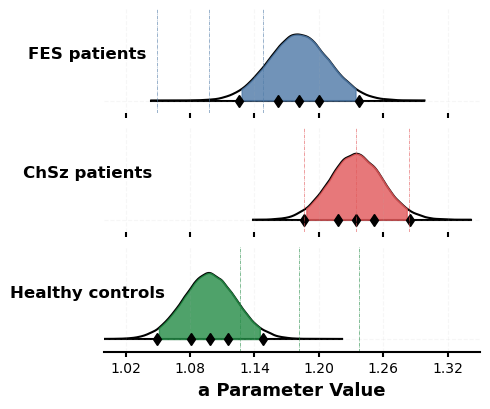

In [26]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# FES（a(3)）与 Healthy（a(1)）已对调
model_data = {
    'FES': m1_infdata.posterior['a(1)'].values.flatten(),       # 原本是 Healthy
    'ChSz': m1_infdata.posterior['a(2)'].values.flatten(),
    'Healthy': m1_infdata.posterior['a(3)'].values.flatten(),   # 原本是 FES
}

# 顺序必须与 model_data 保持一致
parameters = ['a(3)', 'a(2)', 'a(1)']

# 正确颜色顺序：FES蓝、ChSz红、HC青绿色
colors = ['#4E79A7', '#E15759', '#238b45']

fig, axes = plt.subplots(figsize=(5, 4.2), nrows=3, sharex=True)
fig.patch.set_alpha(0)

# 计算全体样本用于统一 x 轴范围
all_data = np.concatenate(list(model_data.values()))
data_min, data_max = np.min(all_data), np.max(all_data)
x_padding = (data_max - data_min) * 0.1
x_min, x_max = data_min - x_padding, data_max + x_padding

for i, (group, samples) in enumerate(model_data.items()):
    axes[i].patch.set_alpha(0)

    az.plot_forest(
        m1_infdata,
        kind='ridgeplot',
        var_names=[parameters[i]],
        ridgeplot_overlap=3.5,
        ridgeplot_truncate=False,
        ridgeplot_quantiles=[.025, .25, .5, .75, .975],
        combined=True,
        colors=[colors[i]],
        ax=axes[i],
        ridgeplot_alpha=0.8
    )
    
    axes[i].grid(True, linestyle='--', alpha=0.1)
    axes[i].set_yticklabels([])
    
    group_quantiles = np.percentile(samples, [2.5, 50, 97.5])
    axes[i].axvline(group_quantiles[0], color=colors[i], linestyle='-.', lw=0.4)
    axes[i].axvline(group_quantiles[1], color=colors[i], linestyle='-.', lw=0.4)
    axes[i].axvline(group_quantiles[2], color=colors[i], linestyle='-.', lw=0.4)

    # Y轴标签
    if group == 'FES':
        ylabel = 'FES patients'
    elif group == 'ChSz':
        ylabel = 'ChSz patients'
    else:
        ylabel = 'Healthy controls'
    axes[i].set_ylabel(ylabel, fontsize=12, rotation=0, labelpad=5, weight='bold')

    axes[i].set_xlim(1.0, 1.35)
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(6))
    axes[i].tick_params(axis='x', labelsize=10, width=1.5)

    for spine in axes[i].spines.values():
        spine.set_visible(False)
    if i == len(model_data) - 1:
        axes[i].spines['bottom'].set_visible(True)
        axes[i].spines['bottom'].set_color('black')
        axes[i].spines['bottom'].set_linewidth(1.5)

plt.xlabel('a Parameter Value', fontsize=13, weight='bold')
plt.tight_layout()

plt.savefig('./6.统计推断-输出/m1/ridgeplot_comparison_optimized-a.jpg', 
            dpi=1200, 
            bbox_inches='tight',
            transparent=True)

plt.show()

##### V参数

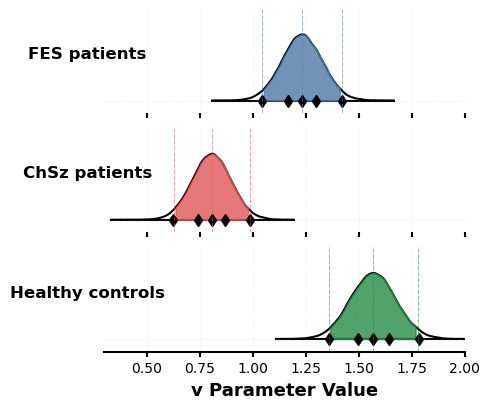

In [27]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# 假设 m1_infdata 已经被正确加载，并且 m1_infdata 包含模型的后验样本
# 将 FES、ChSz 和 Group3 的样本数据提取到 model_data 字典中（参数改为 v）
model_data = {
    'FES': m1_infdata.posterior['v(1)'].values.flatten(),
    'ChSz': m1_infdata.posterior['v(2)'].values.flatten(),
    'Group3': m1_infdata.posterior['v(3)'].values.flatten(),
}

# 设置要绘制的参数名称，与组别对应（改为 v）
parameters = ['v(1)', 'v(2)', 'v(3)']

# 创建具有透明背景的图形，调整为3行子图
fig, axes = plt.subplots(figsize=(5, 4.2), nrows=3, sharex=True)
fig.patch.set_alpha(0)  # 设置整个图形的背景为透明

# 自定义颜色调色板（参考 Nature 配色）
colors = ['#4E79A7', '#E15759', '#238b45']  # 蓝色 (FES)、红色 (ChSz) 和 青绿色 (Group3)

# 计算所有数据的范围以设置统一的 X 轴范围
all_data = np.concatenate(list(model_data.values()))
data_min, data_max = np.min(all_data), np.max(all_data)
x_padding = (data_max - data_min) * 0.1  # 添加10%的边距
x_min, x_max = data_min - x_padding, data_max + x_padding

# 遍历每个组，绘制相应的森林图
for i, (group, samples) in enumerate(model_data.items()):
    # 设置子图背景为透明
    axes[i].patch.set_alpha(0)
    
    # 使用 arviz 绘制森林图
    az.plot_forest(
        m1_infdata,
        kind='ridgeplot',
        var_names=[parameters[i]],
        ridgeplot_overlap=3.5,
        ridgeplot_truncate=False,
        ridgeplot_quantiles=[.025, .25, .5, .75, .975],
        combined=True,
        colors=[colors[i]],
        ax=axes[i],
        ridgeplot_alpha=0.8
    )
    
    # 设置网格线
    axes[i].grid(True, linestyle='--', alpha=0.1)
    axes[i].set_yticklabels([])
    
    # 计算当前组样本的分位数信息
    group_quantiles = np.percentile(samples, [2.5, 50, 97.5])
    
    # 绘制虚线标记分位数
    axes[i].axvline(group_quantiles[0], color=colors[i], linestyle='-.', lw=0.4)
    axes[i].axvline(group_quantiles[1], color=colors[i], linestyle='-.', lw=0.4)
    axes[i].axvline(group_quantiles[2], color=colors[i], linestyle='-.', lw=0.4)
    
    # 设置Y轴标签（加粗）
    if group == 'FES':
        ylabel = 'FES patients'
    elif group == 'ChSz':
        ylabel = 'ChSz patients'
    else:
        ylabel = 'Healthy controls'
    axes[i].set_ylabel(ylabel, fontsize=12, rotation=0, labelpad=5, weight='bold')
    
    # 设置X轴范围和刻度
    axes[i].set_xlim(0.3, 2.0)
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(8))  # 自动生成大约4个主刻度
    axes[i].tick_params(axis='x', labelsize=10, width=1.5)
    
    # 去除所有边框
    for spine in axes[i].spines.values():
        spine.set_visible(False)
    
    # 为最后一个子图单独设置底部边框
    if i == len(model_data) - 1:
        axes[i].spines['bottom'].set_visible(True)
        axes[i].spines['bottom'].set_color('black')
        axes[i].spines['bottom'].set_linewidth(1.5)

# 设置共享的X轴标签（加粗）
plt.xlabel('v Parameter Value', fontsize=13, weight='bold')

# 调整布局
plt.tight_layout()

# 保存图像为1200 dpi，确保透明背景
plt.savefig('./6.统计推断-输出/m1/ridgeplot_comparison_optimized-v.jpg', 
            dpi=1200, 
            bbox_inches='tight',
            transparent=True)

# 显示图像
plt.show()

##### t参数

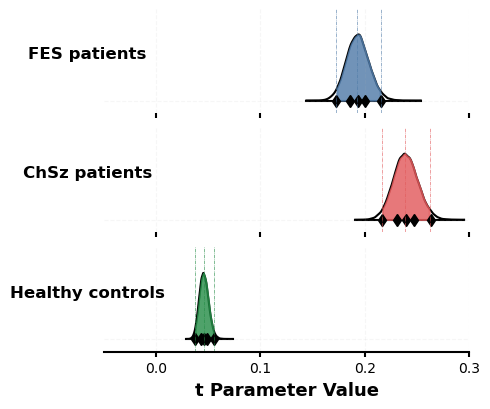

In [28]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# 假设 m1_infdata 已经被正确加载，并且 m1_infdata 包含模型的后验样本
# 将 FES、ChSz 和 Group3 的样本数据提取到 model_data 字典中（参数改为 t）
model_data = {
    'FES': m1_infdata.posterior['t(1)'].values.flatten(),
    'ChSz': m1_infdata.posterior['t(2)'].values.flatten(),
    'Group3': m1_infdata.posterior['t(3)'].values.flatten(),
}

# 设置要绘制的参数名称，与组别对应（改为 t）
parameters = ['t(1)', 't(2)', 't(3)']

# 创建具有透明背景的图形，调整为3行子图
fig, axes = plt.subplots(figsize=(5, 4.2), nrows=3, sharex=True)
fig.patch.set_alpha(0)  # 设置整个图形的背景为透明

# 自定义颜色调色板（参考 Nature 配色）
colors = ['#4E79A7', '#E15759', '#238b45']  # 蓝色 (FES)、红色 (ChSz) 和 青绿色 (Group3)

# 计算所有数据的范围以设置统一的 X 轴范围
all_data = np.concatenate(list(model_data.values()))
data_min, data_max = np.min(all_data), np.max(all_data)
x_padding = (data_max - data_min) * 0.1  # 添加10%的边距
x_min, x_max = data_min - x_padding, data_max + x_padding

# 遍历每个组，绘制相应的森林图
for i, (group, samples) in enumerate(model_data.items()):
    # 设置子图背景为透明
    axes[i].patch.set_alpha(0)
    
    # 使用 arviz 绘制森林图
    az.plot_forest(
        m1_infdata,
        kind='ridgeplot',
        var_names=[parameters[i]],
        ridgeplot_overlap=3.5,
        ridgeplot_truncate=False,
        ridgeplot_quantiles=[.025, .25, .5, .75, .975],
        combined=True,
        colors=[colors[i]],
        ax=axes[i],
        ridgeplot_alpha=0.8
    )
    
    # 设置网格线
    axes[i].grid(True, linestyle='--', alpha=0.1)
    axes[i].set_yticklabels([])
    
    # 计算当前组样本的分位数信息
    group_quantiles = np.percentile(samples, [2.5, 50, 97.5])
    
    # 绘制虚线标记分位数
    axes[i].axvline(group_quantiles[0], color=colors[i], linestyle='-.', lw=0.4)
    axes[i].axvline(group_quantiles[1], color=colors[i], linestyle='-.', lw=0.4)
    axes[i].axvline(group_quantiles[2], color=colors[i], linestyle='-.', lw=0.4)
    
    # 设置Y轴标签（加粗）
    if group == 'FES':
        ylabel = 'FES patients'
    elif group == 'ChSz':
        ylabel = 'ChSz patients'
    else:
        ylabel = 'Healthy controls'
    axes[i].set_ylabel(ylabel, fontsize=12, rotation=0, labelpad=5, weight='bold')
    
    # 设置X轴范围和刻度
    axes[i].set_xlim(-0.05, 0.30)
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(4))  # 自动生成大约4个主刻度
    axes[i].tick_params(axis='x', labelsize=10, width=1.5)
    
    # 去除所有边框
    for spine in axes[i].spines.values():
        spine.set_visible(False)
    
    # 为最后一个子图单独设置底部边框
    if i == len(model_data) - 1:
        axes[i].spines['bottom'].set_visible(True)
        axes[i].spines['bottom'].set_color('black')
        axes[i].spines['bottom'].set_linewidth(1.5)

# 设置共享的X轴标签（加粗）
plt.xlabel('t Parameter Value', fontsize=13, weight='bold')

# 调整布局
plt.tight_layout()

# 保存图像为1200 dpi，确保透明背景
plt.savefig('./6.统计推断-输出/m1/ridgeplot_comparison_optimized-t.jpg', 
            dpi=1200, 
            bbox_inches='tight',
            transparent=True)

# 显示图像
plt.show()

##### z参数

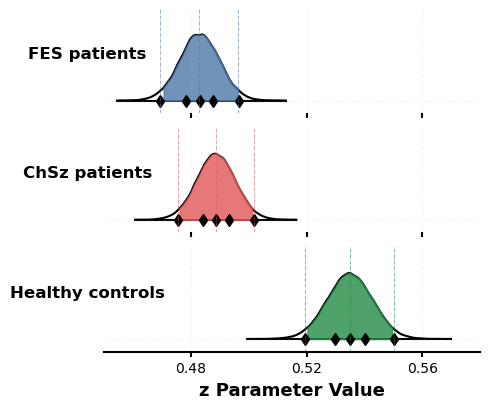

In [29]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

# 假设 m1_infdata 已经被正确加载，并且 m1_infdata 包含模型的后验样本
# 将 FES、ChSz 和 Group3 的样本数据提取到 model_data 字典中（参数改为 z）
model_data = {
    'FES': m1_infdata.posterior['z(1)'].values.flatten(),
    'ChSz': m1_infdata.posterior['z(2)'].values.flatten(),
    'Group3': m1_infdata.posterior['z(3)'].values.flatten(),
}

# 设置要绘制的参数名称，与组别对应（改为 z）
parameters = ['z(1)', 'z(2)', 'z(3)']

# 创建具有透明背景的图形，调整为3行子图
fig, axes = plt.subplots(figsize=(5, 4.2), nrows=3, sharex=True)
fig.patch.set_alpha(0)  # 设置整个图形的背景为透明

# 自定义颜色调色板（参考 Nature 配色）
colors = ['#4E79A7', '#E15759', '#238b45']  # 蓝色 (FES)、红色 (ChSz) 和 青绿色 (Group3)

# 计算所有数据的范围以设置统一的 X 轴范围
all_data = np.concatenate(list(model_data.values()))
data_min, data_max = np.min(all_data), np.max(all_data)
x_padding = (data_max - data_min) * 0.1  # 添加10%的边距
x_min, x_max = data_min - x_padding, data_max + x_padding

# 遍历每个组，绘制相应的森林图
for i, (group, samples) in enumerate(model_data.items()):
    # 设置子图背景为透明
    axes[i].patch.set_alpha(0)
    
    # 使用 arviz 绘制森林图
    az.plot_forest(
        m1_infdata,
        kind='ridgeplot',
        var_names=[parameters[i]],
        ridgeplot_overlap=3.5,
        ridgeplot_truncate=False,
        ridgeplot_quantiles=[.025, .25, .5, .75, .975],
        combined=True,
        colors=[colors[i]],
        ax=axes[i],
        ridgeplot_alpha=0.8
    )
    
    # 设置网格线
    axes[i].grid(True, linestyle='--', alpha=0.1)
    axes[i].set_yticklabels([])
    
    # 计算当前组样本的分位数信息
    group_quantiles = np.percentile(samples, [2.5, 50, 97.5])
    
    # 绘制虚线标记分位数
    axes[i].axvline(group_quantiles[0], color=colors[i], linestyle='-.', lw=0.4)
    axes[i].axvline(group_quantiles[1], color=colors[i], linestyle='-.', lw=0.4)
    axes[i].axvline(group_quantiles[2], color=colors[i], linestyle='-.', lw=0.4)
    
    # 设置Y轴标签（加粗）
    if group == 'FES':
        ylabel = 'FES patients'
    elif group == 'ChSz':
        ylabel = 'ChSz patients'
    else:
        ylabel = 'Healthy controls'
    axes[i].set_ylabel(ylabel, fontsize=12, rotation=0, labelpad=5, weight='bold')
    
    # 设置X轴范围和刻度
    axes[i].set_xlim(0.45, 0.58)
    axes[i].xaxis.set_major_locator(plt.MaxNLocator(4))  # 自动生成大约4个主刻度
    axes[i].tick_params(axis='x', labelsize=10, width=1.5)
    
    # 去除所有边框
    for spine in axes[i].spines.values():
        spine.set_visible(False)
    
    # 为最后一个子图单独设置底部边框
    if i == len(model_data) - 1:
        axes[i].spines['bottom'].set_visible(True)
        axes[i].spines['bottom'].set_color('black')
        axes[i].spines['bottom'].set_linewidth(1.5)

# 设置共享的X轴标签（加粗）
plt.xlabel('z Parameter Value', fontsize=13, weight='bold')

# 调整布局
plt.tight_layout()

# 保存图像为1200 dpi，确保透明背景
plt.savefig('./6.统计推断-输出/m1/ridgeplot_comparison_optimized-z.jpg', 
            dpi=1200, 
            bbox_inches='tight',
            transparent=True)

# 显示图像
plt.show()

In [24]:
print("代码全部完成!")

代码全部完成!
